In [10]:
import numpy as np
import pandas as pd
from os.path import join
from os import listdir
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
## Load individual estimates from NHB paper datasets
path = '/Users/felixmolter/Desktop/gaze-bias-differences/results/estimates/in_sample/GLAM/'
files = listdir(path)

parameters = ['v', 'gamma', 's', 'tau']
estimates = []

for file in files:
    subject = int(file.split('_')[1])
    estimates_i = pd.read_csv(path + file, index_col=0)
    df = pd.DataFrame(dict(subject=subject), index=[subject])
    for parameter in parameters:
        df[parameter] = estimates_i.loc[parameter + '__0_0', 'MAP']
    estimates.append(df)

estimates = pd.concat(estimates).sort_values('subject').reset_index(drop=True)
estimates['dataset'] = 39 * ['Krajbich 2010'] + 30 * ['Krajbich 2011'] + 24 * ['Folke 2016'] + 25 * ['Tavares 2017']

estimates.head(3)

,subject,v,gamma,s,tau,dataset
0,0,0.000084,0.79,0.010750,0.49,Krajbich 2010
1,1,0.000095,-0.13,0.009213,0.22,Krajbich 2010
2,2,0.000024,0.82,0.009846,1.17,Krajbich 2010


# Summary dataframe

In [42]:
estimates_long = pd.melt(estimates,
                         id_vars=['dataset', 'subject'],
                         value_vars=['v', 'gamma', 's', 'tau'],
                         var_name='parameter',
                         value_name='estimate')

summary = estimates_long.groupby(['dataset', 'parameter'])['estimate'].describe()
summary.to_csv('si/individual_estimates_nhb2019_summary.csv')
summary

count      mean       std       min       25%  \
dataset       parameter                                                  
Folke 2016    gamma       24.0 -0.017083  0.282804 -0.500000 -0.250000   
              s           24.0  0.005779  0.001034  0.003731  0.005232   
              tau         24.0  1.752917  1.080336  0.390000  1.077500   
              v           24.0  0.000026  0.000008  0.000017  0.000020   
Krajbich 2010 gamma       39.0  0.262821  0.484197 -0.890000 -0.070000   
              s           39.0  0.008594  0.001744  0.004862  0.007266   
              tau         39.0  0.583077  0.386871  0.010000  0.300000   
              v           39.0  0.000078  0.000033  0.000024  0.000053   
Krajbich 2011 gamma       30.0  0.179000  0.408347 -1.030000 -0.070000   
              s           30.0  0.007724  0.001450  0.005140  0.006695   
              tau         30.0  0.901000  0.840551  0.220000  0.462500   
              v           30.0  0.000067  0.000033  0.000020  0.000044   
Tavares 2017  gamma       25.0  0.080400  0.230552 -0.360000  0.000000   
              s           25.0  0.011494  0.001655  0.007276  0.010866   
              tau         25.0  0.516000  0.238956  0.110000  0.330000   
              v           25.0  0.000086  0.000029  0.000042  0.000057   

                              50%       75%       max  
dataset       parameter                                
Folke 2016    gamma     -0.025000  0.207500  0.460000  
              s          0.005768  0.006359  0.008873  
              tau        1.490000  2.145000  4.630000  
              v          0.000022  0.000029  0.000053  
Krajbich 2010 gamma      0.230000  0.675000  0.970000  
              s          0.008806  0.009685  0.012570  
              tau        0.490000  0.840000  1.750000  
              v          0.000078  0.000094  0.000164  
Krajbich 2011 gamma      0.305000  0.462500  0.810000  
              s          0.007540  0.008579  0.011440  
              tau        0.740000  1.110000  4.820000  
              v          0.000063  0.000077  0.000157  
Tavares 2017  gamma      0.080000  0.190000  0.560000  
              s          0.011449  0.012043  0.014355  
              tau        0.490000  0.710000  0.930000  
              v          0.000091  0.000104  0.000140

# Illustrate individual model estimates from NHB 2019

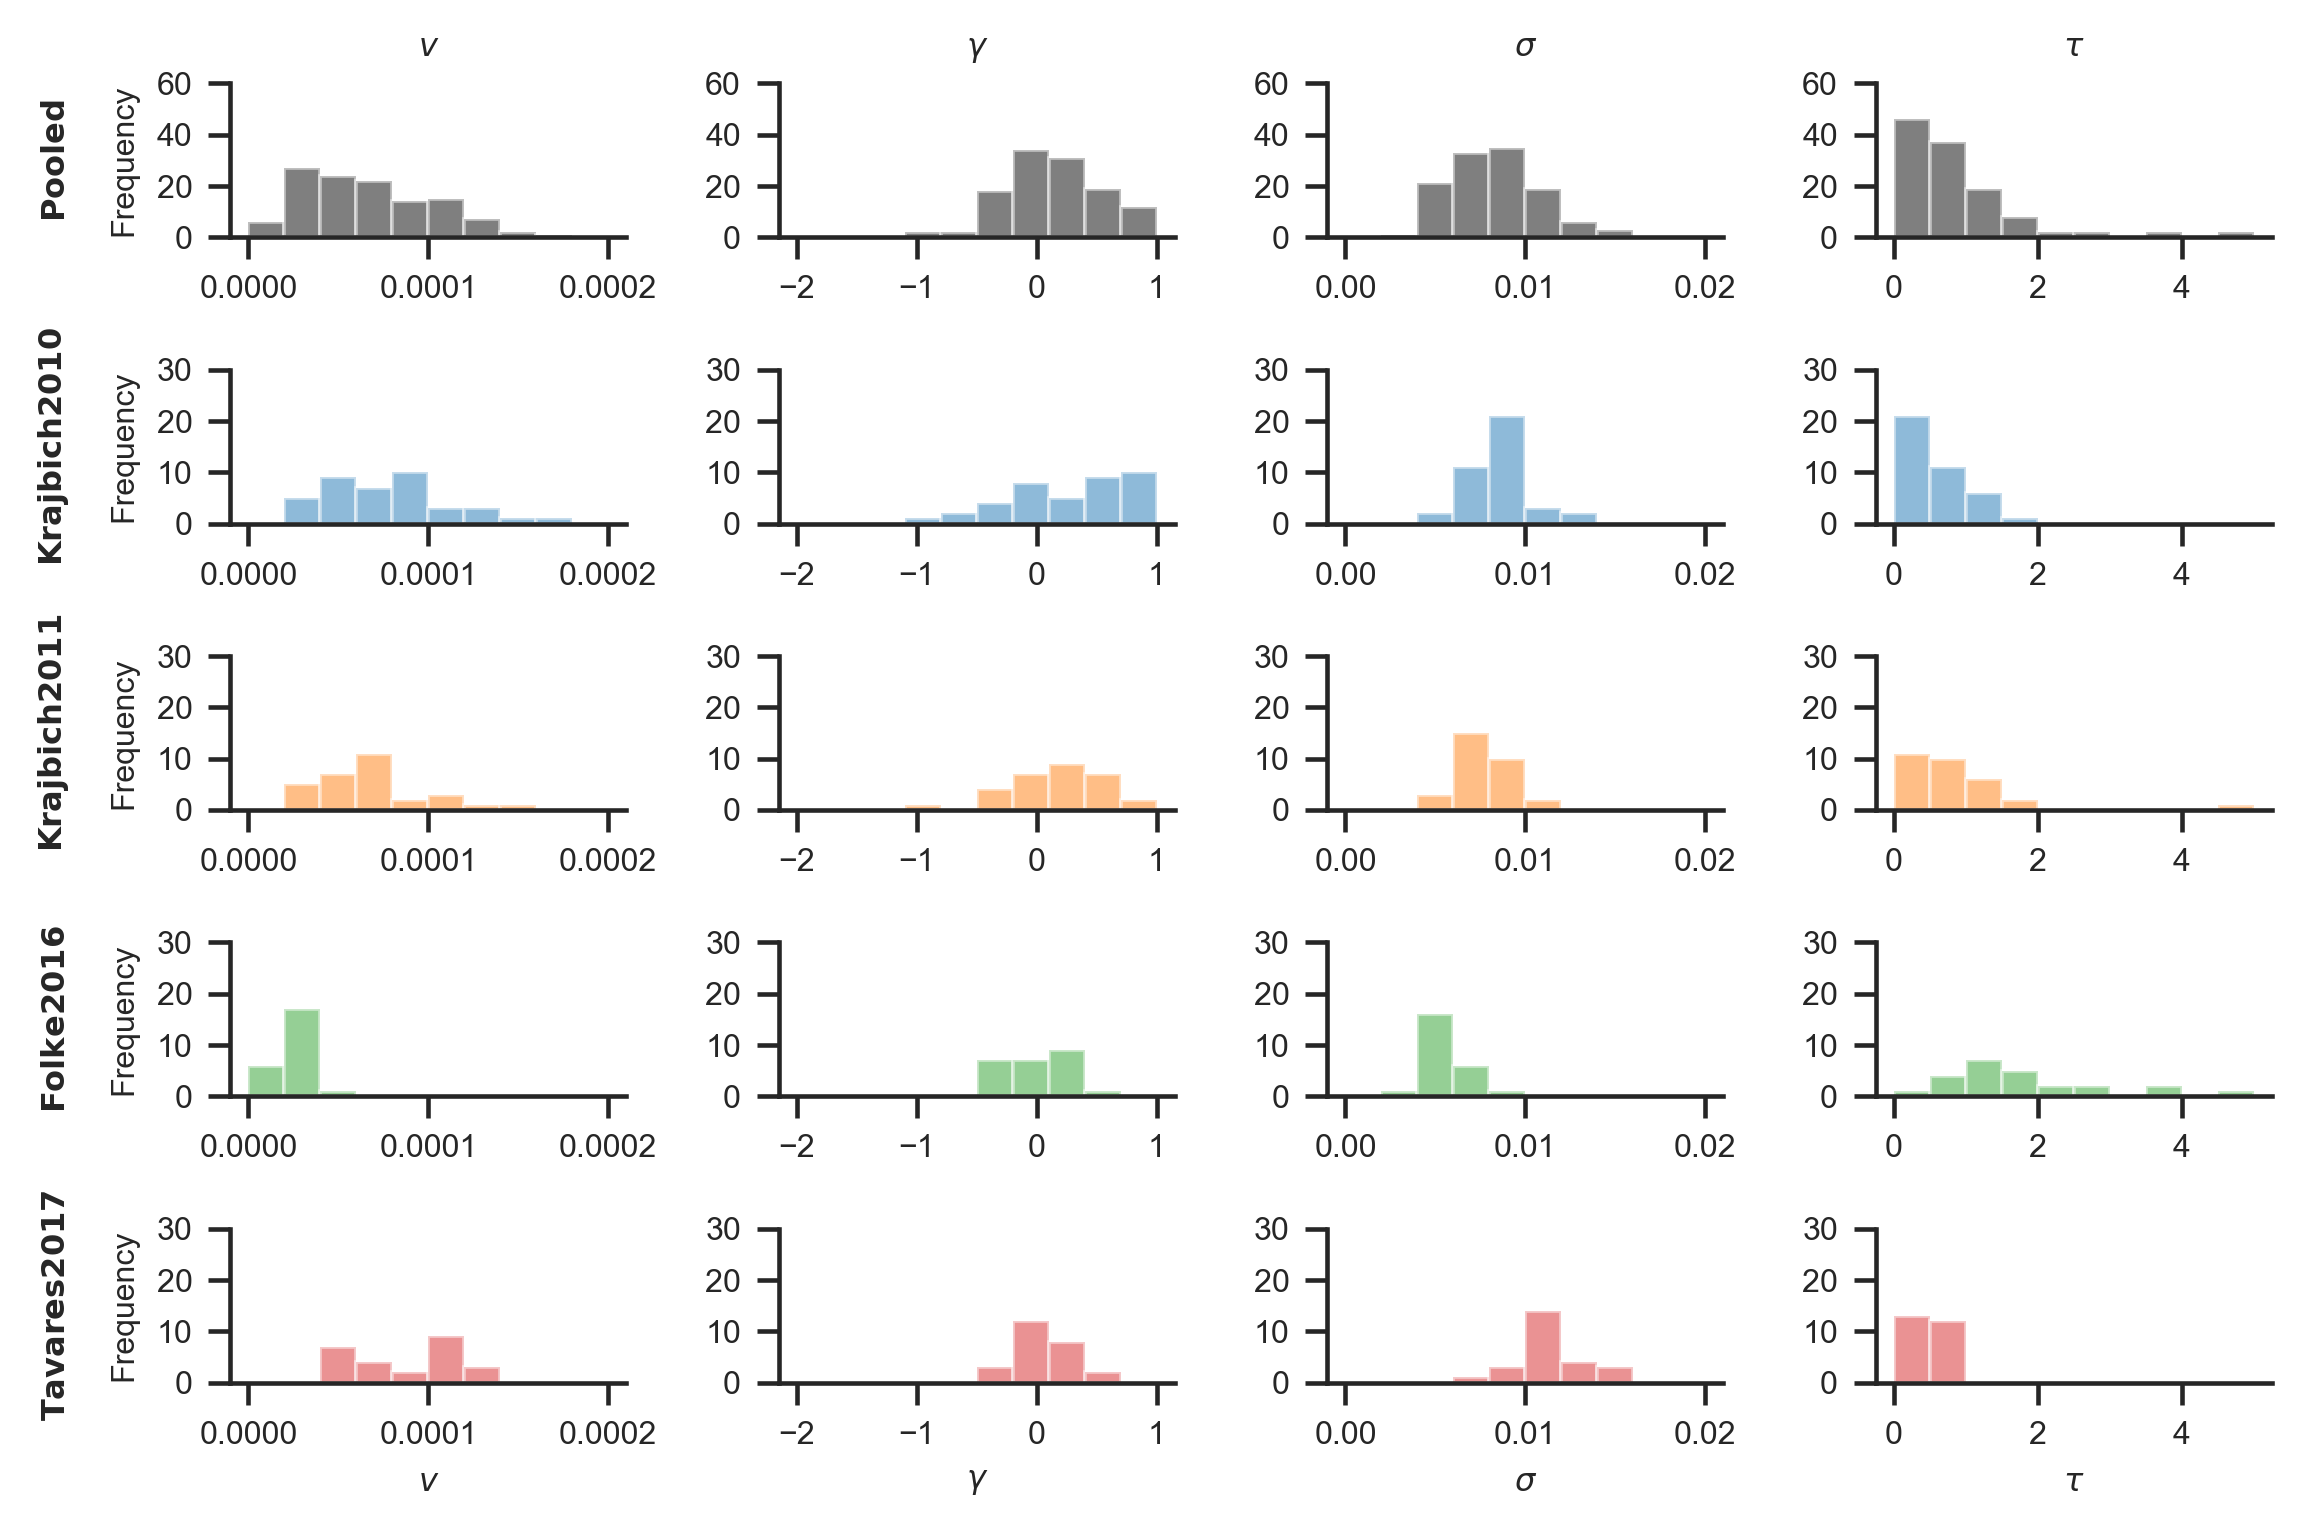

In [25]:
parameters = ['v', 'gamma', 's', 'tau']
parameter_names = dict(v=r'$v$',
                       gamma=r'$\gamma$',
                       s=r'$\sigma$',
                       tau=r'$\tau$')
limits = dict(v=(0, 0.0002),
              gamma=(-2, 1),
              s=(0, 0.02),
              tau=(0, 5))
fontsize = 7
n_bins = 10

datasets = estimates['dataset'].unique()

fig, axs = plt.subplots(len(datasets) + 1,
                        len(parameters),
                        figsize=(gb.plots.cm2inch(18, 12)),
                        dpi=330,
                        sharex='col',
                        sharey='row')

for p, parameter in enumerate(parameters):
    bins = np.linspace(*limits[parameter], n_bins + 1)
    
    # Pooled
    axs[0, p].set_title(parameter_names[parameter], fontsize=fontsize)
    axs[0, p].hist(estimates.loc[:, parameter],
                   bins=bins,
                   color='black',
                   alpha=0.5,
                   edgecolor='white')
    axs[0, p].set_yticks(range(0, 61, 20))
    axs[0, p].set_ylim(0, 60)
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{Pooled}$' + '\n\nFrequency', fontsize=fontsize)

    for d, dataset in enumerate(datasets):
        if p == 0:
            axs[d + 1, 0].set_ylabel(r'$\bf{{{dataset}}}$'.format(dataset=dataset) + '\n\nFrequency',
                                     fontsize=fontsize)
        axs[d + 1, p].hist(
            estimates.loc[estimates['dataset'] == dataset, parameter],
            alpha=0.5,
            edgecolor='white',
            bins=bins,
            color='C{}'.format(d),
            density=False)
        axs[d + 1, p].set_yticks(range(0, 31, 10))
        axs[d + 1, p].set_ylim(0, 30)
        if (d + 1) == len(datasets):
            axs[d + 1, p].set_xlabel(parameter_names[parameter], fontsize=fontsize)

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

fig.tight_layout()
sns.despine()
plt.savefig('si/individual_estimates_nhb2019.png', dpi=330)

# Visualize (hyper)priors implemented in the model

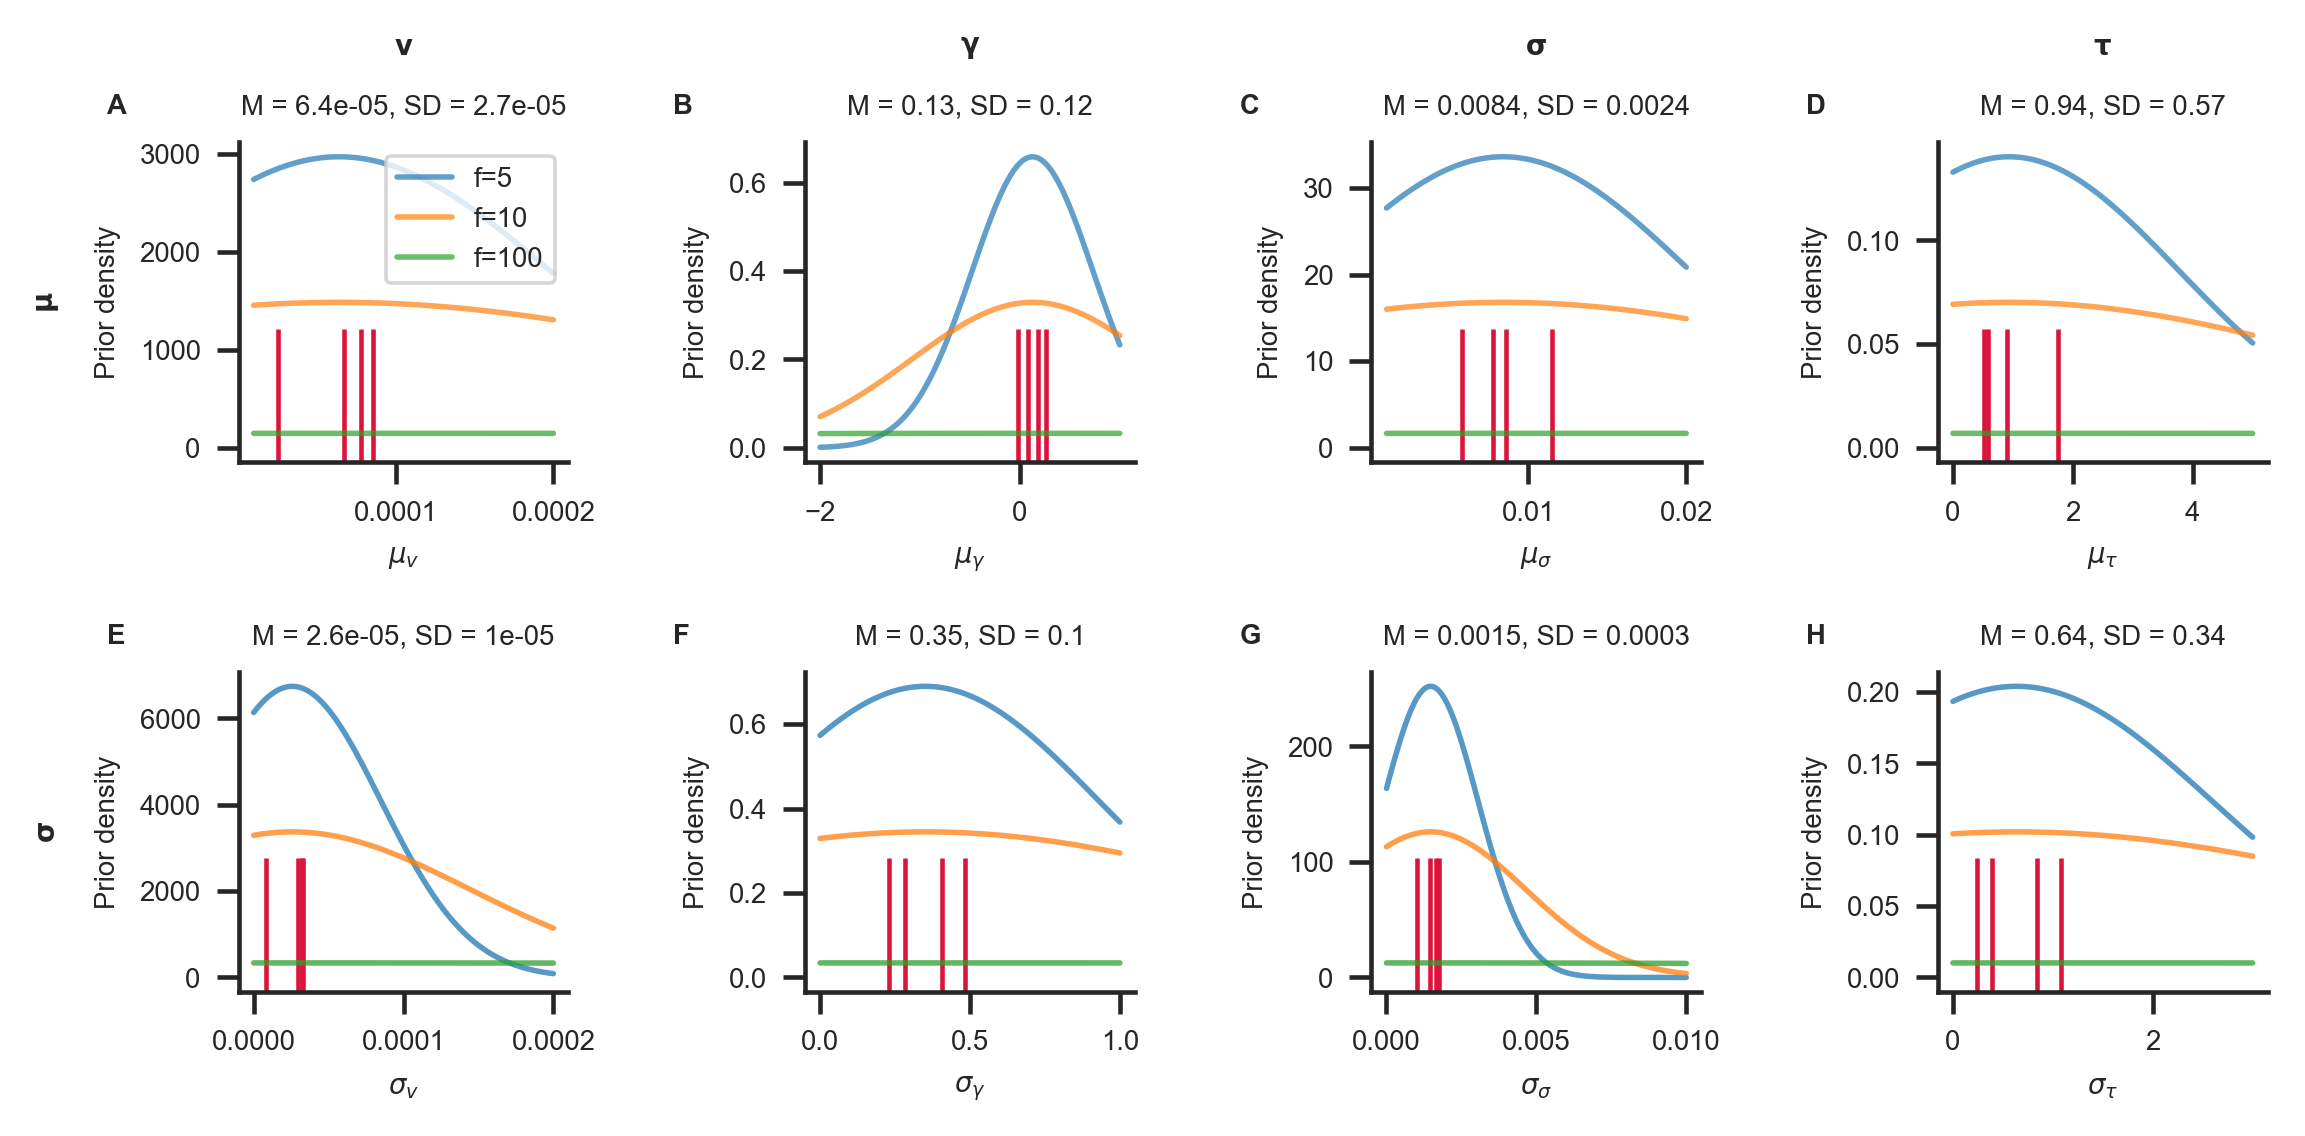

In [6]:
fontsize = 6
fs = [5, 10, 100]

parameters = ['v', 'gamma', 's', 'tau']
parameter_labels = dict(v='v', gamma='\gamma', s='\sigma', tau='\\tau')

bounds = dict(v=dict(mu=(1e-5, 0.0002),
                     sd=(0, 0.0002)),
              gamma=dict(mu=(-2, 1),
                         sd=(0, 1)),
              s=dict(mu=(0.001, 0.02),
                     sd=(0, 0.01)),
              tau=dict(mu=(0, 5),
                       sd=(0, 3)))

from scipy.stats import norm

n_params = len(parameters)

fig, axs = plt.subplots(2, n_params, figsize=gb.plots.cm2inch(18, 9), dpi=330)

for p, parameter in enumerate(parameters):

    # Observed group level parameters from NHB 2019 datasets
    ## Mean
    means = estimates.groupby('dataset')[parameter].mean()
    axs[0, p].plot(means,
                   np.zeros(len(means)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[0, p].set_title(r'$\bf{{{p}}}$'.format(p=parameter_labels[parameter]) +
                        '\n\nM = {}, SD = {}'.format(
                            np.round(means.mean(), precision[parameter]),
                            np.round(means.std(), precision[parameter])),
                        fontsize=fontsize)
    axs[0, p].set_xlabel(r'$\mu_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{\mu}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[0, p].set_ylabel('Prior density', fontsize=fontsize)

    ## SD
    sds = estimates.groupby('dataset')[parameter].std()
    axs[1, p].plot(sds,
                   np.zeros(len(sds)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[1, p].set_title('\n\nM = {}, SD = {}'.format(
        np.round(np.mean(sds), precision[parameter]),
        np.round(np.std(sds), precision[parameter])),
                        fontsize=fontsize)

    axs[1, p].set_xlabel(r'$\sigma_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[1, p].set_ylabel(r'$\bf{\sigma}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[1, p].set_ylabel('Prior density', fontsize=fontsize)


    # Construct priors
    mu_mean = means.mean()  # Mean of prior for group mean is the mean over observed group means
    mu_sd = means.std()     # SD of prior for group mean is the SD over observed group means (times f)
    sd_mean = sds.mean()    # Mean of prior for group SD is the mean over observed group SDs
    sd_sd = sds.std()       # SD of prior for group SD is the SD over observed group SDs (times f)
    
    for i, f in enumerate(fs):

        x_mu = np.linspace(*bounds[parameter]['mu'], 100)
        axs[0, p].plot(x_mu,
                       norm.pdf(x_mu,
                                loc=mu_mean,
                                scale=f*mu_sd),
                       color='C{}'.format(i),
                       alpha=0.7,
                       label='f={}'.format(f))
        x_sd = np.linspace(*bounds[parameter]['sd'], 100)
        axs[1, p].plot(x_sd,
                       norm.pdf(x_sd,
                                loc=sd_mean,
                                scale=f*sd_sd),
                       color='C{}'.format(i),
                       alpha=0.75,
                       label='f={}'.format(f))

# Legend
axs[0, 0].legend(fontsize=fontsize)
        
# Panel Labels
from string import ascii_uppercase
for label, ax in zip(list(ascii_uppercase), axs.ravel()):
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(-0.4,
            1.15,
            label,
            transform=ax.transAxes,
            fontsize=fontsize,
            fontweight='bold',
            va='top')

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
fig.tight_layout(h_pad=-0.2, w_pad=1.2)
plt.savefig(join('si', 'hyperpriors.png'), dpi=330)